In [121]:
import pandas as pd
from io import StringIO
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

## Parameters 

In [122]:
species = "human" # "mouse" , "macaque" , "human"
alignment = "chrM" # "chrM" , "nuDNA" , "mmr", "emr"

def get_ages(species):
    if species == 'macaque':
        tissue_order = ['Younger','Interm_1','Interm_2', 'Older']
    elif species == 'mouse':
        tissue_order = ['Younger', 'Older']
    elif species == 'human':
        tissue_order = ['Younger','Intermediate', 'Older']
    else:
        tissue_order = None
    return tissue_order

age_order = get_ages(species)


def get_tissues(species):
    if species == 'macaque':
        tissue_order = ['Oo', 'M', 'Li']
    elif species == 'mouse':
        tissue_order = ['Oo', 'M', 'Br']
    elif species == 'human':
        tissue_order = ['Oo', 'Sa', 'Bl']
    else:
        tissue_order = None
    return tissue_order

tissue_order = get_tissues(species)


# Mt genome size based on species
def get_genome_size(species):
    if species == 'macaque':
        genome_size = 16564
    elif species == 'mouse':
        genome_size = 16300
    elif species == 'human':
        genome_size = 16569
    else:
        genome_size = None
    return genome_size

genome_size = get_genome_size(species)

## Data

### Filter by mean DCS depth

In [123]:
def filter_dcs_depth(df):
    if species == 'human':
        df = df[df['MeanReadDepth']>40]
    else:
        df = df[df['MeanReadDepth']>90]
    return df
    # print("# Size after filtering by mean DCS depth: " + str(denovo.shape[0]))

### Import seq depth

In [124]:
def get_depth(species):
    # Seq depth information.
    depth = pd.read_table( f"{species}/meanReadDepths.{alignment}.{species}.txt", names=['SRR_ID','MeanReadDepth','Nucleotides'], sep='\s+' )
    depth['Species'] = species
    # Remove merged samples.
    depth = depth[~depth['SRR_ID'].str.contains('merged')]
    # Drop samples below minimum Mean Read Depth.
    depth = filter_dcs_depth(depth)
    return depth

get_depth(species)

,SRR_ID,MeanReadDepth,Nucleotides,Species
0,hs001_Bl,194.192709,3217579,human
1,hs001_Oo1,1719.972780,28498229,human
2,hs002_Oo1,2426.180457,40199384,human
3,hs002_Oo3,344.547710,5708811,human
4,hs002_Oo5,1785.242682,29579686,human
...,...,...,...,...
89,hs023_Oo1,1959.128734,32460804,human
90,hs023_Oo2,1087.038083,18011134,human
91,hs023_Oo3,2201.843020,36482337,human
92,hs023_Oo4,1130.984127,18739276,human


### Import annotations and export sum of nucleotides

In [125]:
def get_annot(species):
    # Species annotations.
    annot = pd.read_table( f"annotations_{species}.txt" )
    # Seq depth info.
    depth = get_depth(species)
    # Add seq depth to annotations.
    annot = pd.merge( annot, depth[['SRR_ID','MeanReadDepth','Nucleotides']], how='right' )

    # # Export annotations including merged samples.
    # annot.to_csv( f"annotations_{species}_merged.txt", sep='\t', index=None )

    # Remove merged samples.
    annot = annot[~annot['SRR_ID'].str.contains('merged')]

    # Export annotations with seq depth.
    annot.to_csv( f"tables/annotations.seqDepth.{alignment}.{species}.txt", sep='\t', index=None )

    return annot


def get_sum_nucleotides():
    list_dfs = []
    for species in ['mouse','macaque','human']:
        annot = get_annot(species)
        annot['Species'] = species
        list_dfs.append(annot)

    df = pd.concat(list_dfs)

    # Export annotations with seq depth.
    df.to_csv( f"tables/annotations.seqDepth.{alignment}.txt", sep='\t', index=None )

    # Get nucleotides sequenced per condition.
    sum_nucleotides = df.groupby(['Species','Tissue','Age_group'])['Nucleotides'].sum().reset_index()
    # Export
    sum_nucleotides.to_csv( f"sum_nucleotides_per_condition.{alignment}.tab", sep='\t', index=None )

    return sum_nucleotides


get_sum_nucleotides()

# test_annots = get_annot( species)
# test_annots#[(test_annots['Individual']=='G137p2')&(test_annots['Tissue']=='Oo')]#['Nucleotides'].sum()


,Species,Tissue,Age_group,Nucleotides
0,human,Bl,Intermediate,5310791
1,human,Bl,Older,11250847
2,human,Bl,Younger,7738150
3,human,Oo,Intermediate,556737175
4,human,Oo,Older,539602351
5,human,Oo,Younger,451721281
6,human,Sa,Intermediate,9702348
7,human,Sa,Older,7567919
8,human,Sa,Younger,8775050
9,macaque,Ht,Interm_2,192591560


### Import Indels

In [126]:
def get_vcf(ref):
    if ref == 'relin':
        file_path = f"{species}/mod.relin.indels.{alignment}.ALL.{species}.vcf"
    elif ref == 'original':
        file_path = f"{species}/mod.indels.{alignment}.ALL.{species}.vcf"
    else:
        ValueError("# ref value not recognized: provide 'total' or 'relin'")
    
    # Define a function to filter out lines starting with '##' but keep those starting with '#'
    def filter_lines(file_path):
        with open(file_path, 'r') as f:
            for line in f:
                if not line.startswith('##'):  # Exclude lines starting with '##'
                    yield line

    # Convert filtered lines into a StringIO object
    filtered_content = StringIO(''.join(filter_lines(file_path)))

    # Use pandas to read the filtered content
    vcf = pd.read_table(filtered_content, comment=None).rename(columns={'#CHROM':'CHROM'})

    # Remove unneccesary columns.
    vcf = vcf.drop(columns=['ID','FORMAT','QUAL','FILTER'])
    vcf = vcf.melt(id_vars=['CHROM','POS','REF','ALT','INFO'], var_name='SRR_ID')

    # Add species column.
    vcf['Species'] = species

    # Remove sites that are reference allele.
    vcf = vcf[vcf['value']!='.:.:.:.']
    # Expand the value column (GT:AC:AF:SB).
    vcf[['AC', 'AF', 'SB']] = vcf['value'].str.split(':', expand=True).iloc[:, 1:].astype(float) # exclude the first value (empty)

    # Compute the fraction of 'N' in the 'ALT' column
    vcf['ALT_Fraction'] = vcf['ALT'].apply(lambda alt: alt.count('N') / len(alt))
    # Compute the fraction of 'N' in the 'REF' column
    vcf['REF_Fraction'] = vcf['REF'].apply(lambda ref: ref.count('N') / len(ref))
    # Compute the element-wise maximum of ALT_Fraction and REF_Fraction
    vcf['N_Fraction'] = vcf[['ALT_Fraction', 'REF_Fraction']].max(axis=1)

    # Indel size.
    vcf['Size_indel'] = vcf['ALT'].str.len()

    # DF copy to filter.
    indels = vcf

    # Annotate with conditions and seq depth info.
    annot = get_annot(species)
    indels = pd.merge( indels, annot[['SRR_ID','Sample_ID','Species','Individual','Age_group','Tissue','Tissue_alt','MeanReadDepth']], how='left' ).reset_index(drop=True)
    # Drop rows where MeanReadDepth is NaN (likely filtered below for cutoff above).
    indels = indels.dropna(subset=['MeanReadDepth'])

    # Drop merged samples.
    indels['Merged?'] = indels['SRR_ID'].str.contains('merged')
    indels = indels[indels['Merged?']==False]

    # Drop SRR with missing info.
    indels = indels[indels['SRR_ID'] != 'SRR10068728']
    # Drop mouse heart and  liver.
    indels = indels[indels['Tissue'] != 'Ht' ]
    if species == 'mouse':
        indels = indels[indels['Tissue'] != 'Li' ]

    # Assign pedigree to mouse samples.
    list_ped_G126 = ['G136','G137','G139','G140']
    list_ped_G129 = ['G131','G132','G133','G134']
    indels['Pedigree'] = None
    indels = indels.dropna(subset=['Sample_ID'])
    indels.loc[indels['Sample_ID'].str.contains('|'.join(list_ped_G126)), 'Pedigree'] = 'G126'
    indels.loc[indels['Sample_ID'].str.contains('|'.join(list_ped_G129)), 'Pedigree'] = 'G129'

    # Reference version.
    indels['Version'] = ref  # Add a column for the version.
    indels['CHROM'] = np.where(indels['Version'] == 'relin', 'chrM_relin', 'chrM')
    return indels


orig_indels = get_vcf('original')
orig_indels

relin_indels = get_vcf('relin')
relin_indels

,CHROM,POS,REF,ALT,INFO,SRR_ID,value,Species,AC,AF,...,Size_indel,Sample_ID,Individual,Age_group,Tissue,Tissue_alt,MeanReadDepth,Merged?,Pedigree,Version
0,chrM_relin,1077,GT,G,SB=1.91346;AF=0.005;AC=0,hs001_Bl,.:1:0.005:1.91346,human,1.0,0.005000,...,1,hs001_Bl,hs001,Younger,Bl,Bl,194.192709,False,None,relin
1,chrM_relin,3466,A,AC,SB=1.80374;AF=0.0006035;AC=0,hs001_Bl,.:1:0.00515464:1.80374,human,1.0,0.005155,...,2,hs001_Bl,hs001,Younger,Bl,Bl,194.192709,False,None,relin
2,chrM_relin,6219,A,AC,SB=1.92405;AF=0.00653595;AC=0,hs001_Bl,.:1:0.00653595:1.92405,human,1.0,0.006536,...,2,hs001_Bl,hs001,Younger,Bl,Bl,194.192709,False,None,relin
3,chrM_relin,8469,A,AN,SB=1.21569;AF=0.0178571;AC=0,hs001_Bl,.:1:0.015873:1.21569,human,1.0,0.015873,...,2,hs001_Bl,hs001,Younger,Bl,Bl,194.192709,False,None,relin
4,chrM_relin,8471,A,AC,SB=0.402273;AF=0.00175131;AC=0,hs001_Bl,.:1:0.0163934:0.402273,human,1.0,0.016393,...,2,hs001_Bl,hs001,Younger,Bl,Bl,194.192709,False,None,relin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263,chrM_relin,13920,A,AN,SB=1.8429;AF=0.000606428;AC=0,hs014_Oo3,.:1:0.000606428:1.82019,human,1.0,0.000606,...,2,hs014_Oo3,hs014,Intermediate,Oo,Oo3,1312.668658,False,None,relin
2264,chrM_relin,14859,G,GN,SB=2.13624;AF=0.000734214;AC=0,hs014_Oo3,.:1:0.000734214:1.94264,human,1.0,0.000734,...,2,hs014_Oo3,hs014,Intermediate,Oo,Oo3,1312.668658,False,None,relin
2265,chrM_relin,14861,A,AN,SB=1.93249;AF=0.000733138;AC=0,hs014_Oo3,.:1:0.000733138:1.93249,human,1.0,0.000733,...,2,hs014_Oo3,hs014,Intermediate,Oo,Oo3,1312.668658,False,None,relin
2266,chrM_relin,15570,C,CN,SB=1.79462;AF=0.000852515;AC=0,hs014_Oo3,.:1:0.000852515:1.85975,human,1.0,0.000853,...,2,hs014_Oo3,hs014,Intermediate,Oo,Oo3,1312.668658,False,None,relin


In [127]:
orig_indels[(orig_indels['Individual']=='G137p2')&(orig_indels['Tissue_alt']=='Oo3')&(~orig_indels['ALT'].str.contains('N'))].iloc[:,:20].sort_values('POS')

,CHROM,POS,REF,ALT,INFO,SRR_ID,value,Species,AC,AF,SB,ALT_Fraction,REF_Fraction,N_Fraction,Size_indel,Sample_ID,Individual,Age_group,Tissue,Tissue_alt


## Relinearized variants

In [128]:
## Realigns the relinearized positions to match the original reference.
## The "relin_POS" column keeps the positions from the relinearized reference.
def fix_relin_pos(species,df_relin):
    # Select genome size based on species (mouse, macaque).
    if species == 'mouse':
        genome_size = 16300
    elif species == 'macaque':
        genome_size = 16564
    elif species == 'human':
        genome_size = 16569
    else:
        ValueError("### Species not recognized ###")
    # Specify that this is from the relinearized sequence.
    df_relin['CHROM'] = 'chrM'
    # Keep relinearized position in another column.
    df_relin['relin_POS'] = df_relin['POS']
    # Fixing the position to match the original reference.
    ###df_relin['POS'] += -8165 #macaque
    df_relin['POS'] += (8400 - genome_size - 1)
    ###df_relin.loc[df_relin['POS'] <= 0, 'POS'] += 16564 #macaque
    df_relin.loc[df_relin['POS'] <= 0, 'POS'] += genome_size
    # Sort by new position.
    df_relin = df_relin.sort_values('relin_POS')
    return df_relin.drop_duplicates()

def merge_indels(indels,relin_indels):
    # Shift position of relin indels.
    relin = fix_relin_pos(species,relin_indels)
    relin = relin.loc[
        (relin['POS'] >= 0) & (relin['POS'] <= 1000) |
        (relin['POS'] >= (genome_size - 1000)) & (relin['POS'] <= genome_size)
    ]
    # Subset the original indels.
    original = indels.loc[
        (indels['POS'] > 1000) & (indels['POS'] <= genome_size - 1000)
    ]
    # Merge non-overlapping subsets.
    indels = pd.concat([original, relin])
    return indels


indels = merge_indels( orig_indels, relin_indels )
indels


,CHROM,POS,REF,ALT,INFO,SRR_ID,value,Species,AC,AF,...,Sample_ID,Individual,Age_group,Tissue,Tissue_alt,MeanReadDepth,Merged?,Pedigree,Version,relin_POS
9,chrM,7464,A,AC,SB=1.86316;AF=0.00166945;AC=0,hs001_Bl,.:1:0.00561798:1.86316,human,1.0,0.005618,...,hs001_Bl,hs001,Younger,Bl,Bl,194.192709,False,None,original,NaN
10,chrM,9476,GT,G,SB=1.91346;AF=0.005;AC=0,hs001_Bl,.:1:0.005:1.91346,human,1.0,0.005000,...,hs001_Bl,hs001,Younger,Bl,Bl,194.192709,False,None,original,NaN
11,chrM,11865,A,AC,SB=1.80374;AF=0.00170358;AC=0,hs001_Bl,.:1:0.00515464:1.80374,human,1.0,0.005155,...,hs001_Bl,hs001,Younger,Bl,Bl,194.192709,False,None,original,NaN
12,chrM,14618,A,AC,SB=1.92405;AF=0.00653595;AC=0,hs001_Bl,.:1:0.00653595:1.92405,human,1.0,0.006536,...,hs001_Bl,hs001,Younger,Bl,Bl,194.192709,False,None,original,NaN
57,chrM,1040,TA,T,SB=1.93099;AF=0.0289855;AC=0,hs001_Oo1,.:1:0.000507357:1.93099,human,1.0,0.000507,...,hs001_Oo1,hs001,Younger,Oo,Oo1,1719.972780,False,None,original,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,chrM,960,TCCC,T,SB=1.79519;AF=0.00258065;AC=0,hs010_Oo6,.:2:0.00258065:1.79519,human,2.0,0.002581,...,hs010_Oo6,hs010,Younger,Oo,Oo6,739.193735,False,None,relin,9130.0
1530,chrM,991,TA,T,SB=2.07942;AF=0.00778388;AC=0,hs011_Oo3,.:17:0.00778388:2.07942,human,17.0,0.007784,...,hs011_Oo3,hs011,Older,Oo,Oo3,1885.199046,False,None,relin,9161.0
1880,chrM,992,A,AN,SB=1.76371;AF=0.00199203;AC=0,hs012_Sa,.:1:0.00199203:1.76371,human,1.0,0.001992,...,hs012_Sa,hs012,Older,Sa,Sa,391.500935,False,None,relin,9162.0
931,chrM,996,A,AN,SB=1.98772;AF=0.00052521;AC=0,hs007_Oo2,.:1:0.00052521:1.98772,human,1.0,0.000525,...,hs007_Oo2,hs007,Older,Oo,Oo2,1624.724063,False,None,relin,9166.0


### Plot histogram of positions

(0.0, 16468.0)

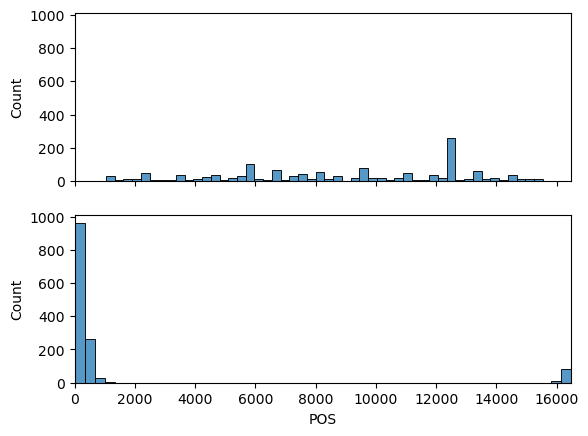

In [129]:
fig,axes = plt.subplots( 2,1, sharex=True, sharey=True )
sns.histplot( data=indels[indels['Version']=='original'], x='POS', bins=50, ax=axes[0], legend=False )
sns.histplot( data=indels[indels['Version']=='relin'], x='POS', bins=50, ax=axes[1], legend=False )
plt.xlim([0,indels['POS'].max()])

## Filtering by N_fraction

### Filter by N_fraction

# Size after filtering by N_fraction: 512


(0.0, 16373.0)

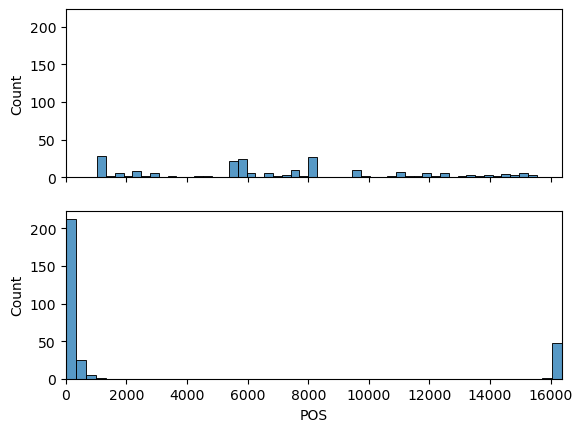

In [130]:
n_cutoff = 0.0 #0.1

# Remove REF/ALT with N's.
filtered_indels = indels[indels['N_Fraction']<= n_cutoff ].copy()
filtered_indels
print("# Size after filtering by N_fraction: " + str(filtered_indels.shape[0]))

# Plot histogram of positions.
fig,axes = plt.subplots( 2,1, sharex=True, sharey=True )
sns.histplot( data=filtered_indels[filtered_indels['Version']=='original'], x='POS', bins=50, ax=axes[0], legend=False )
sns.histplot( data=filtered_indels[filtered_indels['Version']=='relin'], x='POS', bins=50, ax=axes[1], legend=False )
plt.xlim([0,filtered_indels['POS'].max()])

#### Observe N's in ALT/REF alleles

In [131]:
# # Alleles within the N fraction cutoff.
indels[(indels['N_Fraction']<= 1 )&(indels['N_Fraction']>0.5)]

,CHROM,POS,REF,ALT,INFO,SRR_ID,value,Species,AC,AF,...,Sample_ID,Individual,Age_group,Tissue,Tissue_alt,MeanReadDepth,Merged?,Pedigree,Version,relin_POS
125,chrM,8560,C,CNN,SB=1.86537;AF=0.000467508;AC=0,hs002_Oo1,.:1:0.000467508:1.86537,human,1.0,0.000468,...,hs002_Oo1,hs002,Intermediate,Oo,Oo1,2426.180457,False,None,original,NaN
223,chrM,10606,C,CNN,SB=2.77456;AF=0.000606061;AC=0,hs002_Oo5,.:1:0.000606061:2.77456,human,1.0,0.000606,...,hs002_Oo5,hs002,Intermediate,Oo,Oo5,1785.242682,False,None,original,NaN
242,chrM,14176,A,ANN,SB=1.91153;AF=0.00056243;AC=0,hs002_Oo5,.:1:0.00056243:1.91153,human,1.0,0.000562,...,hs002_Oo5,hs002,Intermediate,Oo,Oo5,1785.242682,False,None,original,NaN
476,chrM,14182,A,ANN,SB=2.08085;AF=0.000615006;AC=0,hs004_Oo2,.:1:0.000615006:2.08085,human,1.0,0.000615,...,hs004_Oo2,hs004,Older,Oo,Oo2,1719.265979,False,None,original,NaN
712,chrM,10243,C,CNNN,SB=1.796;AF=0.000592417;AC=0,hs006_Oo1,.:1:0.000592417:1.796,human,1.0,0.000592,...,hs006_Oo1,hs006,Younger,Oo,Oo1,2410.336653,False,None,original,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,chrM,523,C,CNN,SB=1.8257;AF=0.00126582;AC=0,hs007_Oo4,.:1:0.00126582:2.64222,human,1.0,0.001266,...,hs007_Oo4,hs007,Older,Oo,Oo4,931.342869,False,None,relin,8693.0
2258,chrM,523,C,CANNN,SB=1.69106;AF=0.00126582;AC=0,hs014_Oo3,.:1:0.00126582:1.69106,human,1.0,0.001266,...,hs014_Oo3,hs014,Intermediate,Oo,Oo3,1312.668658,False,None,relin,8693.0
2141,chrM,523,C,CNCNN,SB=1.83008;AF=0.00253165;AC=0,hs014_Oo2,.:1:0.00086881:1.70818,human,1.0,0.000869,...,hs014_Oo2,hs014,Intermediate,Oo,Oo2,1978.686583,False,None,relin,8693.0
2138,chrM,523,C,CNN,SB=1.8257;AF=0.00126582;AC=0,hs014_Oo2,.:1:0.00086881:1.70818,human,1.0,0.000869,...,hs014_Oo2,hs014,Intermediate,Oo,Oo2,1978.686583,False,None,relin,8693.0


<Axes: title={'center': 'Fraction of bases that are N in the ALT allele'}, ylabel='Frequency'>

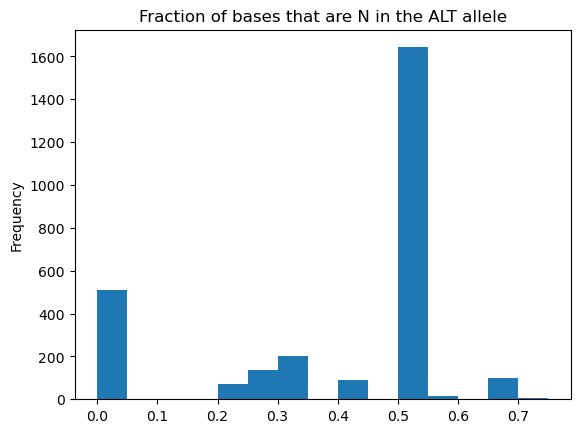

In [132]:
indels['N_Fraction'].plot(kind='hist', bins=15, title='Fraction of bases that are N in the ALT allele')

## Classify: Variants with ambiguous timing of occurrence during development
- Inheritable heteroplasmies ( Somat + | Germ + ).
- Somatic mutations or low-freq heteroplasmy ( Somat + | Germ - ).
- Potential early germline mutations ( Somat - | Germ + ).

In [133]:
# Get unique identifier for each mutation in each individual and tissue type.
to_classify = filtered_indels[['POS','REF','ALT','Tissue','Tissue_alt','Individual','Sample_ID','Pedigree']]

# Classify somatic and germline tissues.
to_classify = to_classify.copy()
to_classify['Tissue_type'] = to_classify['Tissue'].map({'Bl': 'somatic', 'Sa': 'somatic', 'Oo': 'germline', 'M':'somatic', 'Li':'somatic', 'Br':'somatic', 'Ht':'somatic' })

to_classify

,POS,REF,ALT,Tissue,Tissue_alt,Individual,Sample_ID,Pedigree,Tissue_type
9,7464,A,AC,Bl,Bl,hs001,hs001_Bl,None,somatic
10,9476,GT,G,Bl,Bl,hs001,hs001_Bl,None,somatic
11,11865,A,AC,Bl,Bl,hs001,hs001_Bl,None,somatic
12,14618,A,AC,Bl,Bl,hs001,hs001_Bl,None,somatic
57,1040,TA,T,Oo,Oo1,hs001,hs001_Oo1,None,germline
...,...,...,...,...,...,...,...,...,...
779,864,A,AATGTT,Oo,Oo3,hs006,hs006_Oo3,None,germline
780,865,ACCCC,A,Oo,Oo3,hs006,hs006_Oo3,None,germline
1312,954,A,AAT,Oo,Oo6,hs010,hs010_Oo6,None,germline
1313,960,TCCC,T,Oo,Oo6,hs010,hs010_Oo6,None,germline


In [134]:
get_annot(species)

,SRR_ID,Sample_ID,Individual,Tissue,Tissue_alt,Species,Age,Age_group,MeanReadDepth,Nucleotides
0,hs001_Bl,hs001_Bl,hs001,Bl,Bl,human,27.0,Younger,194.192709,3217579
1,hs001_Oo1,hs001_Oo1,hs001,Oo,Oo1,human,27.0,Younger,1719.972780,28498229
2,hs002_Oo1,hs002_Oo1,hs002,Oo,Oo1,human,34.0,Intermediate,2426.180457,40199384
3,hs002_Oo3,hs002_Oo3,hs002,Oo,Oo3,human,34.0,Intermediate,344.547710,5708811
4,hs002_Oo5,hs002_Oo5,hs002,Oo,Oo5,human,34.0,Intermediate,1785.242682,29579686
...,...,...,...,...,...,...,...,...,...,...
77,hs023_Oo1,hs023_Oo1,hs023,Oo,Oo1,human,33.0,Intermediate,1959.128734,32460804
78,hs023_Oo2,hs023_Oo2,hs023,Oo,Oo2,human,33.0,Intermediate,1087.038083,18011134
79,hs023_Oo3,hs023_Oo3,hs023,Oo,Oo3,human,33.0,Intermediate,2201.843020,36482337
80,hs023_Oo4,hs023_Oo4,hs023,Oo,Oo4,human,33.0,Intermediate,1130.984127,18739276


In [135]:
# Initialize the 'Classification' column
to_classify['Classification'] = None

# Define a unique mutation ID using POS, REF, and ALT
to_classify['Mutation_ID'] = to_classify['POS'].astype(str) + '_' + to_classify['REF'] + '_' + to_classify['ALT']

# Iterate over each individual to classify mutations
for individual in to_classify['Individual'].unique():
    individual_data = to_classify[to_classify['Individual'] == individual]
    
    # Identify somatic and germline mutations for the individual
    somatic_mutations = individual_data[individual_data['Tissue_type'] == 'somatic']
    germline_mutations = individual_data[individual_data['Tissue_type'] == 'germline']

    for idx, row in individual_data.iterrows():
        mutation_id = row['Mutation_ID']
        
        # Get somatic and germline occurrences of the mutation ID
        somatic_ids = somatic_mutations['Mutation_ID'].values
        germline_ids = germline_mutations['Mutation_ID'].values

        # Mutations in both somatic and germline tissues.
        if mutation_id in somatic_ids and mutation_id in germline_ids:
            to_classify.at[idx, 'Classification'] = 'Inheritable'
            continue
        
        elif mutation_id in somatic_ids and mutation_id not in germline_ids:
            # Somatic tissues for this mutation ID
            somatic_tissues = somatic_mutations[somatic_mutations['Mutation_ID'] == mutation_id]['Tissue_alt'].unique()
            
            if len(somatic_tissues) > 1:  # Present in both somatic tissues
                to_classify.at[idx, 'Classification'] = 'Shared Somatic'
            else:
                to_classify.at[idx, 'Classification'] = 'Somatic de novo'
        
        elif mutation_id in germline_ids and mutation_id not in somatic_ids:
            # Germline tissues for this mutation ID
            germline_tissues = germline_mutations[germline_mutations['Mutation_ID'] == mutation_id]['Tissue_alt'].unique()
            if len(germline_tissues) > 1:   # Present in more than one oocyte
                to_classify.at[idx, 'Classification'] = 'Shared Germline'
            else:
                to_classify.at[idx, 'Classification'] = 'Germline de novo'
        
        else:
            to_classify.at[idx, 'Classification'] = 'Unclassified'


# Group by Pedigree and Mutation_ID to classify mutations within pedigrees
to_classify['Pedigree_shared'] = None

for mutation_id in to_classify['Mutation_ID'].unique():
    mutation_data = to_classify[to_classify['Mutation_ID'] == mutation_id]
    
    # Count unique pedigrees sharing the mutation
    unique_pedigrees = mutation_data['Pedigree'].nunique()
    
    if unique_pedigrees > 1:
        # Mutation is shared across different pedigrees
        to_classify.loc[mutation_data.index, 'Pedigree_shared'] = 'Between pedigrees'
    else:
        for pedigree in mutation_data['Pedigree'].unique():
            pedigree_data = mutation_data[mutation_data['Pedigree'] == pedigree]
            
            # Count unique individuals sharing the mutation within the same pedigree
            unique_individuals = pedigree_data['Individual'].nunique()
            
            if unique_individuals > 1:
                # Mutation is shared across individuals in the same pedigree
                to_classify.loc[pedigree_data.index, 'Pedigree_shared'] = 'Shared in Pedigree'
            else:
                # Mutation is unique to a single individual in the pedigree
                to_classify.loc[pedigree_data.index, 'Pedigree_shared'] = 'Unique to Individual'

# Merge and export the classified data
classified = pd.merge(filtered_indels, to_classify, how='left')
classified.to_csv(f"tables/indels.classified.{alignment}_{species}.tab", index=False, sep='\t')

# Summarize classification counts
summary = classified['Classification'].value_counts().reset_index(name='No_mutations')
summary


,Classification,No_mutations
0,Inheritable,194
1,Germline de novo,143
2,Shared Germline,99
3,Somatic de novo,74
4,Shared Somatic,2


In [136]:
to_classify[to_classify['Mutation_ID']=='6115_GA_G']

,POS,REF,ALT,Tissue,Tissue_alt,Individual,Sample_ID,Pedigree,Tissue_type,Classification,Mutation_ID,Pedigree_shared


In [137]:
classified[classified['Mutation_ID']=='6115_GA_G'][['Sample_ID','Mutation_ID','Tissue_type']]

,Sample_ID,Mutation_ID,Tissue_type


### Filter indels by mutation class and pedigree

In [138]:
# Get de novo indels.
denovo = classified[classified['Classification'].str.contains('de novo')]
# if species == 'mouse':
#     denovo = classified[(classified['Pedigree_shared'].isin(['Shared in Pedigree','Unique to Individual']))&(classified['Classification'].str.contains('de novo'))]
denovo = denovo.drop_duplicates()
denovo

,CHROM,POS,REF,ALT,INFO,SRR_ID,value,Species,AC,AF,...,Tissue_alt,MeanReadDepth,Merged?,Pedigree,Version,relin_POS,Tissue_type,Classification,Mutation_ID,Pedigree_shared
2,chrM,11865,A,AC,SB=1.80374;AF=0.00170358;AC=0,hs001_Bl,.:1:0.00515464:1.80374,human,1.0,0.005155,...,Bl,194.192709,False,None,original,NaN,somatic,Somatic de novo,11865_A_AC,None
3,chrM,14618,A,AC,SB=1.92405;AF=0.00653595;AC=0,hs001_Bl,.:1:0.00653595:1.92405,human,1.0,0.006536,...,Bl,194.192709,False,None,original,NaN,somatic,Somatic de novo,14618_A_AC,None
5,chrM,5893,A,AC,SB=1.88737;AF=0.00148588;AC=0,hs002_Oo1,.:1:0.000319081:1.88737,human,1.0,0.000319,...,Oo1,2426.180457,False,None,original,NaN,germline,Germline de novo,5893_A_AC,None
6,chrM,14208,AACT,A,SB=2.56573;AF=0.00286533;AC=0,hs002_Oo3,.:1:0.00286533:2.56573,human,1.0,0.002865,...,Oo3,344.547710,False,None,original,NaN,germline,Germline de novo,14208_AACT_A,None
7,chrM,7093,T,TC,SB=2.20303;AF=0.000511509;AC=0,hs002_Oo5,.:1:0.000511509:2.20303,human,1.0,0.000512,...,Oo5,1785.242682,False,None,original,NaN,germline,Germline de novo,7093_T_TC,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,chrM,864,A,AATGTT,SB=2.38069;AF=0.000582072;AC=0,hs006_Oo3,.:1:0.000582072:2.38069,human,1.0,0.000582,...,Oo3,1557.517352,False,None,relin,9034.0,germline,Germline de novo,864_A_AATGTT,None
508,chrM,865,ACCCC,A,SB=2.38183;AF=0.000582072;AC=0,hs006_Oo3,.:1:0.000582072:2.38183,human,1.0,0.000582,...,Oo3,1557.517352,False,None,relin,9035.0,germline,Germline de novo,865_ACCCC_A,None
509,chrM,954,A,AAT,SB=1.92242;AF=0.00256082;AC=0,hs010_Oo6,.:2:0.00256082:1.92242,human,2.0,0.002561,...,Oo6,739.193735,False,None,relin,9124.0,germline,Germline de novo,954_A_AAT,None
510,chrM,960,TCCC,T,SB=1.79519;AF=0.00258065;AC=0,hs010_Oo6,.:2:0.00258065:1.79519,human,2.0,0.002581,...,Oo6,739.193735,False,None,relin,9130.0,germline,Germline de novo,960_TCCC_T,None


In [139]:
denovo.sort_values('Mutation_ID')

,CHROM,POS,REF,ALT,INFO,SRR_ID,value,Species,AC,AF,...,Tissue_alt,MeanReadDepth,Merged?,Pedigree,Version,relin_POS,Tissue_type,Classification,Mutation_ID,Pedigree_shared
104,chrM,1036,AAC,A,SB=2.14286;AF=0.00311526;AC=0,hs011_Sa,.:1:0.0111111:2.14286,human,1.0,0.011111,...,Sa,65.250770,False,None,original,NaN,somatic,Somatic de novo,1036_AAC_A,None
114,chrM,1036,AAC,A,SB=2.14286;AF=0.00311526;AC=0,hs012_Oo2,.:1:0.00102354:1.70966,human,1.0,0.001024,...,Oo2,802.717002,False,None,original,NaN,germline,Germline de novo,1036_AAC_A,None
181,chrM,1036,AAC,A,SB=2.14286;AF=0.00311526;AC=0,hs022_Bl,.:1:0.00311526:1.85384,human,1.0,0.003115,...,Bl,255.726115,False,None,original,NaN,somatic,Somatic de novo,1036_AAC_A,None
164,chrM,1040,TA,T,SB=1.93099;AF=0.0289855;AC=0,hs021_Bl,.:2:0.0289855:2.08106,human,2.0,0.028986,...,Bl,64.799626,False,None,original,NaN,somatic,Somatic de novo,1040_TA_T,None
14,chrM,1040,TA,T,SB=1.93099;AF=0.0289855;AC=0,hs003_Sa,.:1:0.00483092:1.8524,human,1.0,0.004831,...,Sa,186.443599,False,None,original,NaN,somatic,Somatic de novo,1040_TA_T,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,chrM,960,TCCC,T,SB=1.79519;AF=0.00258065;AC=0,hs010_Oo6,.:2:0.00258065:1.79519,human,2.0,0.002581,...,Oo6,739.193735,False,None,relin,9130.0,germline,Germline de novo,960_TCCC_T,None
37,chrM,9650,CAT,C,SB=1.63636;AF=0.0138889;AC=0,hs006_Bl,.:1:0.0138889:1.63636,human,1.0,0.013889,...,Bl,60.331885,False,None,original,NaN,somatic,Somatic de novo,9650_CAT_C,None
56,chrM,9720,AT,A,SB=1.71093;AF=0.00584795;AC=0,hs008_Bl,.:1:0.00584795:1.71093,human,1.0,0.005848,...,Bl,139.154868,False,None,original,NaN,somatic,Somatic de novo,9720_AT_A,None
119,chrM,9793,A,AT,SB=1.50789;AF=0.00102354;AC=0,hs012_Oo2,.:1:0.00102354:1.50789,human,1.0,0.001024,...,Oo2,802.717002,False,None,original,NaN,germline,Germline de novo,9793_A_AT,None


## Filterings (pt 2)

### Filter by MAF

In [140]:
# # Removes indel with high AF from a sample (not across all samples for the individual).
# denovo = denovo[denovo['AF']<0.01].copy()

# Filter out a position with high AF from all tissues in an individual.
denovo = denovo.copy()
denovo.loc[:, 'Filter_ID'] = denovo['Individual'] + '_' + denovo['POS'].astype(str)

maf_blacklist = denovo[denovo['AF'] > 0.01]['Filter_ID'].unique()
maf_blacklist

denovo = denovo[~denovo['Filter_ID'].isin(maf_blacklist)].copy()


print("# Size after filtering by MAF: " + str(denovo.shape[0]))

# Size after filtering by MAF: 183


### Filter potential artifacts

In [141]:
# Variants to exclude (may span multiple loci in the VCF but should likely be the same event). ##

if species == 'macaque':
    # Sample Rh064 has a high freq variant at 8239 (should be excluded by previous filter).
    blacklist_indexes = classified[(classified['Individual'] == 'Rh064') & (classified['POS'] == 8239)].index
    denovo = denovo[~denovo.index.isin(blacklist_indexes)]
    # # Exclude this problem region with a microsatellite (POS 253-272) present in all macaque (29/30).
    # denovo = denovo[~denovo['POS'].isin(range(253, 273))]
    # # Exclude these regions within microsatellites (POS 8684, 297) for macaques.
    # denovo = denovo[~denovo['POS'].isin([8684, 297])]

# elif species == 'human':
#     # Seen in > 100 samples in previous versions.
#     denovo = denovo[~denovo['P'].isin([308,309])]

# elif species == 'mouse':
#     # Seen in > 100 samples in previous versions.
#     denovo = denovo[~denovo['P'].isin([5167,5171])]

print("# Size after filtering potential artifacts: " + str(denovo.shape[0]))

# Size after filtering potential artifacts: 183


In [142]:
classified[(classified['POS']>=5167)&(classified['POS']<= 5171)][['Species','Mutation_ID']]#.value_counts()

,Species,Mutation_ID


In [143]:
# # Related mutations overlapping multiple positions in VCF (277-279)
denovo[(denovo['POS']>=5167)&(denovo['POS']<= 5171)].sort_values(['POS'])#.head()

,CHROM,POS,REF,ALT,INFO,SRR_ID,value,Species,AC,AF,...,MeanReadDepth,Merged?,Pedigree,Version,relin_POS,Tissue_type,Classification,Mutation_ID,Pedigree_shared,Filter_ID


## Individual (Sample_ID) frequencies (Dloop vs. non-Dloop)

- Annotates these gene regions for the denovo df
- One row per oocyte

In [144]:
# Species-specific genome size and ranges from species_info
species_info = {
    'mouse': {'Dloop_range': (15424, 16300), 'non_Dloop_range': (1, 15423), 'Dloop_size': 877, 'genome_size': 16300},
    'macaque': {'Dloop_range': (16015, 16564), 'non_Dloop_range': (536, 16014), 'Dloop_size': 1085, 'genome_size': 16564},
    'human': {'Dloop_range': (16024, 16569), 'non_Dloop_range': (577, 16023), 'Dloop_size': 1122, 'genome_size': 16569}
}

# Define the species you are working with
genome_size = species_info[species]['genome_size']
dloop_range = species_info[species]['Dloop_range']
non_dloop_range = species_info[species]['non_Dloop_range']
dloop_size = species_info[species]['Dloop_size']
non_dloop_size = abs(dloop_size - genome_size)

# Function to assign region sizes
def assign_region(row, dloop_range, non_dloop_range, dloop_size, non_dloop_size):
    if non_dloop_range[0] <= row['POS'] <= non_dloop_range[1]:
        return pd.Series(['non-D-loop', non_dloop_size])
    else:
        return pd.Series(['D-loop', dloop_size])  # In case it's outside the defined regions

# Apply the function to assign regions and calculate Region_size
denovo[['Region', 'Region_size']] = denovo.apply(
    assign_region, 
    axis=1, 
    args=(dloop_range, non_dloop_range, dloop_size, non_dloop_size)
)


# Compute frequencies at D-loop and non-D-loop separately
subset_columns = ['Species', 'Region', 'Sample_ID', 'Age_group', 'Tissue', 'Individual', 'MeanReadDepth','Region_size']
region_freqs = denovo.copy().groupby(subset_columns).size().reset_index(name='No_mutations')
region_freqs['Frequency'] = region_freqs['No_mutations'] / (region_freqs['MeanReadDepth'] * region_freqs['Region_size'])

# Filter for D-loop and non-D-loop
dloop_freqs = region_freqs[region_freqs['Region'] == 'D-loop']
non_dloop_freqs = region_freqs[region_freqs['Region'] == 'non-D-loop']

# Compute the total genome frequencies by grouping by the same columns as the D-loop and non-D-loop frequencies
subset_columns = ['Species', 'Sample_ID', 'Age_group', 'Tissue', 'Individual', 'MeanReadDepth']
total_freqs = denovo.copy().groupby(subset_columns).size().reset_index(name='No_mutations')
total_freqs['Region_size'] = genome_size
total_freqs['Region'] = 'Total'
total_freqs['Nucleotides'] = (total_freqs['MeanReadDepth'] * genome_size).astype(int)
total_freqs['Frequency'] = total_freqs['No_mutations'] / (total_freqs['Nucleotides'])

# Merge the D-loop frequencies, non-D-loop frequencies
merge_columns = ['Species', 'Sample_ID', 'Age_group', 'Tissue', 'Individual', 'MeanReadDepth']
merged_freqs = pd.merge(dloop_freqs[['Species', 'Sample_ID', 'Age_group', 'Tissue', 'Individual', 'Region_size', 'MeanReadDepth', 'No_mutations', 'Frequency']],
                        non_dloop_freqs[['Species', 'Sample_ID', 'Age_group', 'Tissue', 'Individual', 'Region_size', 'MeanReadDepth', 'No_mutations', 'Frequency']],
                        how="outer",
                        on=merge_columns,
                        suffixes=('_Dloop', '_NonDloop'))

# Merge with the total genome frequencies
merged_freqs = pd.merge(merged_freqs, total_freqs[['Species', 'Sample_ID', 'Age_group', 'Tissue', 'Individual', 'Region_size', 'MeanReadDepth', 'Nucleotides', 'No_mutations', 'Frequency']],
                        on=merge_columns, how='outer')


# Fill missing values in Freq, Region size and number of mutations.
def fill_missing_values(df):
    # Define the prefixes
    prefixes = ('Frequency_', 'No_mutations_')
    # Get column names that start with the specified prefixes
    columns_to_fill = [col for col in df.columns if col.startswith(prefixes)]
    # Fill NaN with 0 in the specified columns
    df[columns_to_fill] = df[columns_to_fill].fillna(0)
    return df
merged_freqs['Region_size_Dloop'] = dloop_size
merged_freqs['Region_size_NonDloop'] = non_dloop_size
merged_freqs['Nucleotides_Dloop'] = (merged_freqs['MeanReadDepth'] * dloop_size).astype(int)
merged_freqs['Nucleotides_NonDloop'] = (merged_freqs['MeanReadDepth'] * non_dloop_size).astype(int)
merged_freqs = fill_missing_values(merged_freqs)


# Save the merged table
merged_freqs.to_csv(f"tables/individuals.Dloop.denovo_{alignment}_{species}.tab", index=None, sep="\t")

# Check the output
merged_freqs.head(15)

,Species,Sample_ID,Age_group,Tissue,Individual,Region_size_Dloop,MeanReadDepth,No_mutations_Dloop,Frequency_Dloop,Region_size_NonDloop,No_mutations_NonDloop,Frequency_NonDloop,Region_size,Nucleotides,No_mutations,Frequency,Nucleotides_Dloop,Nucleotides_NonDloop
0,human,hs001_Bl,Younger,Bl,hs001,1122,194.192709,0.0,0.000000e+00,15447,2.0,6.667345e-07,16569,3217578,2,6.215856e-07,217884,2999694
1,human,hs001_Oo1,Younger,Oo,hs001,1122,1719.972780,6.0,3.109115e-06,15447,0.0,0.000000e+00,16569,28498229,6,2.105394e-07,1929809,26568419
2,human,hs002_Oo1,Intermediate,Oo,hs002,1122,2426.180457,0.0,0.000000e+00,15447,1.0,2.668288e-08,16569,40199384,1,2.487600e-08,2722174,37477209
3,human,hs002_Oo3,Intermediate,Oo,hs002,1122,344.547710,2.0,5.173540e-06,15447,1.0,1.878912e-07,16569,5708811,3,5.255035e-07,386582,5322228
4,human,hs002_Oo5,Intermediate,Oo,hs002,1122,1785.242682,7.0,3.494684e-06,15447,2.0,7.252514e-08,16569,29579686,9,3.042629e-07,2003042,27576643
5,human,hs003_Oo3,Younger,Oo,hs003,1122,1306.782727,3.0,2.046091e-06,15447,5.0,2.476980e-07,16569,21652082,8,3.694795e-07,1466210,20185872
6,human,hs003_Sa,Younger,Sa,hs003,1122,186.443599,1.0,4.780350e-06,15447,4.0,1.388892e-06,16569,3089184,5,1.618550e-06,209189,2879994
7,human,hs004_Bl,Older,Bl,hs004,1122,511.568954,2.0,3.484440e-06,15447,8.0,1.012376e-06,16569,8476186,10,1.179776e-06,573980,7902205
8,human,hs004_Oo2,Older,Oo,hs004,1122,1719.265979,1.0,5.183989e-07,15447,2.0,7.530829e-08,16569,28486518,3,1.053130e-07,1929016,26557501
9,human,hs005_Oo3,Younger,Oo,hs005,1122,1754.342024,2.0,1.016068e-06,15447,0.0,0.000000e+00,16569,29067693,2,6.880491e-08,1968371,27099321


## Export de novo mutations

### One indel per row

In [145]:
denovo.to_csv( f"indels/indels.denovo_{alignment}_{species}.tab", index=None, sep="\t" )

In [ ]:
denovo[denovo['POS']<600]['Region'].unique()

array(['D-loop'], dtype=object)

## Summarize mutations

### Histogram of mtDNA indels

Text(0.5, 1.0, 'Aligned chrM (human)')

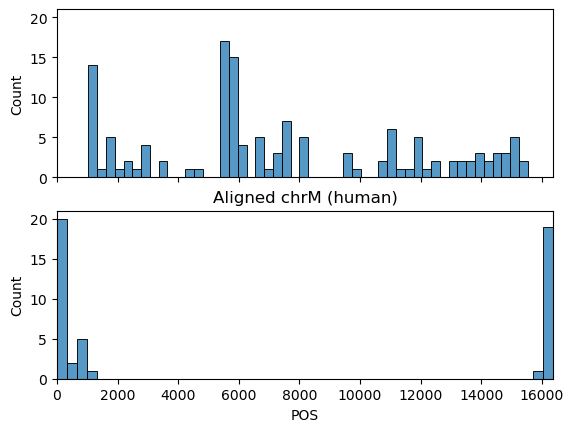

In [147]:
### Plot histogram of positions
fig,axes = plt.subplots( 2,1, sharex=True, sharey=True )
sns.histplot( data=denovo[denovo['Version']=='original'], x='POS', bins=50, ax=axes[0], legend=False )
sns.histplot( data=denovo[denovo['Version']=='relin'], x='POS', bins=50, ax=axes[1], legend=False )
plt.xlim([0,denovo['POS'].max()])
plt.title(f'Aligned {alignment} ({species})')

### Sum of nucleotides from reads in alignment

In [148]:
sum_nucleotides = get_sum_nucleotides()
sum_nucleotides

,Species,Tissue,Age_group,Nucleotides
0,human,Bl,Intermediate,5310791
1,human,Bl,Older,11250847
2,human,Bl,Younger,7738150
3,human,Oo,Intermediate,556737175
4,human,Oo,Older,539602351
5,human,Oo,Younger,451721281
6,human,Sa,Intermediate,9702348
7,human,Sa,Older,7567919
8,human,Sa,Younger,8775050
9,macaque,Ht,Interm_2,192591560


### Prepare the Fisher's exact test function

In [149]:
import pandas as pd
from scipy.stats import fisher_exact

def perform_fishers_test(df, group_cols=['Species', 'Tissue'], count_col='No_mutations', sum_col='Nucleotides', age_group='Age_group', young_label='Younger', old_label='Older', alternative='greater'):
    """
    Perform one-sided Fisher's exact test between Younger and Older age groups for specified groups.

    Parameters:
        df (pd.DataFrame): Input dataframe containing mutation counts and nucleotide totals.
        group_cols (list): Columns to group by (e.g., ['Species', 'Tissue']).
        count_col (str): Column with mutation counts.
        sum_col (str): Column with total nucleotide counts.
        age_group (str): Column indicating age group.
        young_label (str): Label for the younger age group.
        old_label (str): Label for the older age group.
        alternative (str): Direction for Fisher's exact test ('greater', 'less', or 'two-sided').

    Returns:
        pd.DataFrame: A dataframe with Fisher's test results.
    """
    fisher_results = []

    # Group data by specified columns
    for group_values, group_data in df.groupby(group_cols, observed=False):
        # Subset data for Younger and Older age groups
        younger = group_data[group_data[age_group] == young_label]
        older = group_data[group_data[age_group] == old_label]
        
        # Ensure both age groups are present
        if not younger.empty and not older.empty:
            # Extract mutation counts and nucleotide sums
            younger_mutations = younger[count_col].values[0]
            older_mutations = older[count_col].values[0]
            younger_nucleotides = younger[sum_col].values[0] - younger_mutations
            older_nucleotides = older[sum_col].values[0] - older_mutations
            
            # Create the contingency table
            contingency_table = [
                [older_mutations, older_nucleotides],
                [younger_mutations, younger_nucleotides],
                
            ]
            
            # Perform Fisher's exact test
            _, p_value = fisher_exact(contingency_table, alternative=alternative)
            
            # Prepare result row
            result = dict(zip(group_cols, group_values))
            result.update({'P_value': p_value})
            fisher_results.append(result)

    # Convert results to a DataFrame
    results = pd.DataFrame(fisher_results)
    # Add stars to p-values.
    results = assign_p_value_stars(results)
    # Merge with input df.
    df = pd.merge( df, results, how='left' )
    return df


def assign_p_value_stars(df, p_value_col='P_value', thresholds=[0.001, 0.01, 0.05], stars=["***", "**", "*", "ns"]):
    """
    Assign stars based on p-value significance levels.
    """
    # Ensure thresholds and stars are aligned
    if len(stars) != len(thresholds) + 1:
        raise ValueError("The length of `stars` must be one greater than `thresholds`.")
    
    # Function to assign stars based on p-value
    def get_stars(p):
        for i, threshold in enumerate(thresholds):
            if p <= threshold:
                return stars[i]
        return stars[-1]  # No significance
    
    # Apply the star assignment function to the p_value column
    df['Stars'] = df[p_value_col].apply(get_stars)
    
    return df

### Count all mutations 

In [150]:
# Count mutations.
mutations = denovo[['Species','Tissue', 'Age_group']].value_counts().reset_index(name='No_mutations')
mutations = pd.merge( mutations, sum_nucleotides, how='left' )
mutations['Frequency'] = mutations['No_mutations'] / mutations['Nucleotides']

# Convert the 'Age_group' and 'Tissue' columns to categorical types with specified order
mutations['Tissue'] = pd.Categorical(mutations['Tissue'], categories=tissue_order, ordered=True)
mutations['Age_group'] = pd.Categorical(mutations['Age_group'], categories=age_order, ordered=True)

# Sort by Age_group and Tissue explicitly to enforce the custom order
mutations = mutations.sort_values(by=['Tissue', 'Age_group']).reset_index(drop=True)

# # Fisher's exact test between Younger and Older age groups.
# mutations = perform_fishers_test(mutations)

# Export table.
mutations.to_csv( f"tables/freqs.denovo_indels.{alignment}_{species}.txt", index=None, sep="\t" )
mutations

,Species,Tissue,Age_group,No_mutations,Nucleotides,Frequency
0,human,Oo,Younger,45,451721281,9.961895e-08
1,human,Oo,Intermediate,35,556737175,6.286629e-08
2,human,Oo,Older,57,539602351,1.056333e-07
3,human,Sa,Younger,7,8775050,7.977163e-07
4,human,Sa,Intermediate,11,9702348,1.133746e-06
5,human,Sa,Older,6,7567919,7.928203e-07
6,human,Bl,Younger,6,7738150,7.753791e-07
7,human,Bl,Intermediate,6,5310791,1.129775e-06
8,human,Bl,Older,10,11250847,8.888220e-07
